# Malaysia COVID-19 Statistics Forecasting

Author : Wong Zhao Wu, Bryan

# Modelling Objective
- To perform EDA and Identify key COVID-19 trend throughout the period.
- To forecast key COVID-19 statistics including positivity rates, number of daily cases, number of new deaths based on other measures like hospital capacity, number of MySejahtera(contact tracing solution) checkins and contact tracing capabilities.
- To provide suggestions on COVID-19 measures based on forecasting and data analytics insights.

## Keywords
- Supervised Learning
- COVID-19
- Time-Series Forecasting
- ACF & PACF
- SARIMAX

In [1]:
import itertools
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import statsmodels as sm
import sklearn
from tqdm import tqdm
from statsmodels.tsa.stattools import acf, adfuller
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

# Load Dataset

## Update Dataset
By running the following cell, the `etl/etl.py` script will fetch the latest Malaysia COVID-19 statistics on [MoH-Malaysia / covid19-public](https://github.com/MoH-Malaysia/covid19-public) GitHub repository and update `etl/malaysia_covid_daily_stats.csv`.

In [2]:
%cd ETL
%run etl.py
%cd ..

C:\Users\wongz\OneDrive\daaa_y2s1\AIML\CA\CA2\Paper\Malaysia COVID19 Forecast\ETL
Updated Successfully Until : 2021-08-06 00:00:00
C:\Users\wongz\OneDrive\daaa_y2s1\AIML\CA\CA2\Paper\Malaysia COVID19 Forecast


## Import Dataset

In [3]:
covid_stats_df = pd.read_csv('etl/malaysia_covid_daily_stats.csv')
covid_stats_df.index = pd.to_datetime(covid_stats_df.date) # Set date to index
covid_stats_df.drop(columns='date', inplace=True) # Drop date column
covid_stats_df.tail()

,cases_new,deaths_new,total_test,checkins,unique_ind,unique_loc,casual_contacts,total_beds_available,admitted_covid,discharged_covid,hosp_covid,bed_icu_covid,icu_covid,vent_covid
date,,,,,,,,,,,,,,
2021-08-02,15764,219,146276,19955687,8389175,699644,74145,80198,2140,1753,13636,1488,1451,902
2021-08-03,17105,195,170477,20056135,8428884,706107,63611,80325,2207,1821,13461,1512,1460,898
2021-08-04,19819,257,157885,19966088,8414552,708624,72578,80363,2420,1733,13972,1514,1484,910
2021-08-05,20596,164,154386,19975283,8417547,707028,72578,80366,2144,1879,13962,1520,1462,914
2021-08-06,20889,160,157612,20112071,8385104,671537,69412,80778,2695,2079,14049,1520,1493,938


In [4]:
covid_stats_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 159 entries, 2021-03-01 to 2021-08-06
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   cases_new             159 non-null    int64
 1   deaths_new            159 non-null    int64
 2   total_test            159 non-null    int64
 3   checkins              159 non-null    int64
 4   unique_ind            159 non-null    int64
 5   unique_loc            159 non-null    int64
 6   casual_contacts       159 non-null    int64
 7   total_beds_available  159 non-null    int64
 8   admitted_covid        159 non-null    int64
 9   discharged_covid      159 non-null    int64
 10  hosp_covid            159 non-null    int64
 11  bed_icu_covid         159 non-null    int64
 12  icu_covid             159 non-null    int64
 13  vent_covid            159 non-null    int64
dtypes: int64(14)
memory usage: 18.6 KB


# EDA
1. Covid-19 Cases Details 

    [`cases_new`, `deaths_new`, `total_test`]
2. Mysejahtera Check-in Details 

    [`checkins`, `unique_ind`, `unique_loc`, `casual_contacts`]
3. Patient Details

    [`hosp_covid`, `icu_covid`, `vent_covid`]
3. Hospitalisation Details 

    [`net_hospital_admission`, `bed_occupation`, `covid_icu_bed_occupation`]

In [5]:
covid19_case_columns = ['cases_new', 'deaths_new', 'total_test', 'positive_rate']
mysejahtera_columns = ['checkins', 'unique_ind', 'unique_loc', 'casual_contacts']
patient_columns = ['hosp_covid', 'icu_covid', 'vent_covid']
hospitalisation_columns = ['net_hospital_admission', 'bed_occupation', 'covid_icu_bed_occupation']

# Basic Features Calculation
covid_stats_df['positive_rate'] = covid_stats_df['cases_new']/covid_stats_df['total_test']
covid_stats_df['net_hospital_admission'] = covid_stats_df['admitted_covid'] - covid_stats_df['discharged_covid']
covid_stats_df['bed_occupation'] = covid_stats_df['hosp_covid']/covid_stats_df['total_beds_available']
covid_stats_df['covid_icu_bed_occupation'] = covid_stats_df['icu_covid']/covid_stats_df['bed_icu_covid'] 

## Covid-19 Cases Statistics

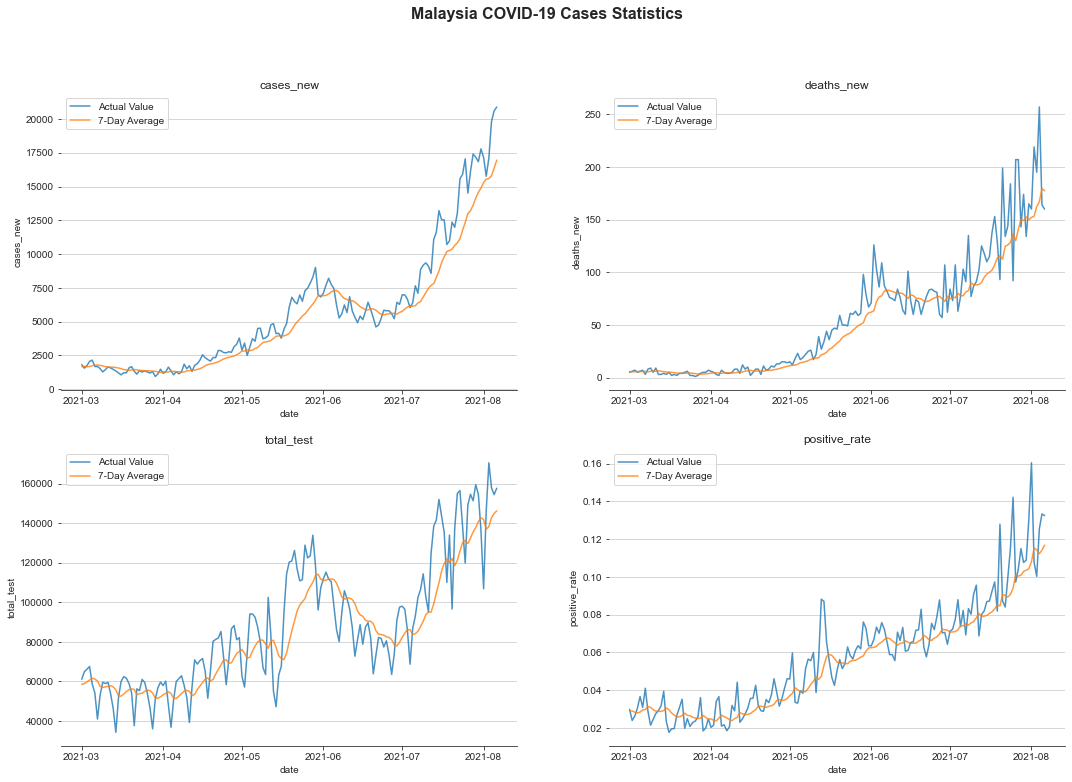

In [6]:
sns.set_style("ticks")
warnings.filterwarnings("ignore")
fig, axes = plt.subplots(2,2,figsize = (18, 12))
for idx, col in enumerate(covid19_case_columns):
    sns.lineplot(x='date', y=col, data = covid_stats_df, label='Actual Value', alpha=0.8, ax = axes[idx//2, idx%2]) # Actual Data
    sns.lineplot(data=ExponentialSmoothing(covid_stats_df[col]).fit(smoothing_level=0.14).fittedvalues, label='7-Day Average', alpha=0.8, ax = axes[idx//2, idx%2]) # Smoothed Value
    sns.despine(top=True, right = True, left=True)
    axes[idx//2, idx%2].set_title(col)
    axes[idx//2, idx%2].grid(axis='y')

fig.suptitle("Malaysia COVID-19 Cases Statistics", fontsize=16, fontweight='bold')
plt.legend()
plt.show()

## MySejahtera Statistics

### Human Traffic

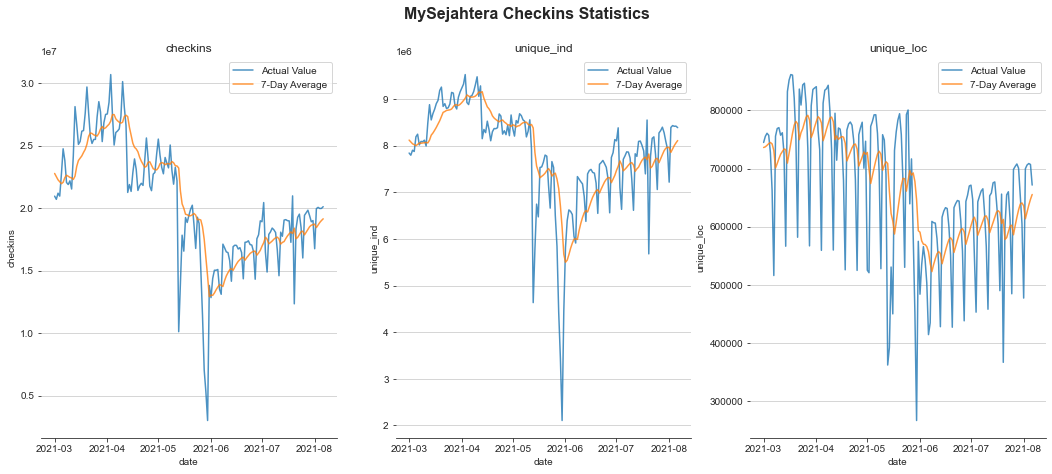

In [7]:
sns.set_style("ticks")
warnings.filterwarnings("ignore")
fig, axes = plt.subplots(1,3,figsize = (18, 7))
for idx, col in enumerate(mysejahtera_columns[:3]):
    sns.lineplot(x='date', y=col, data = covid_stats_df, label='Actual Value', alpha=0.8, ax = axes[idx]) # Actual Data
    sns.lineplot(data=ExponentialSmoothing(covid_stats_df[col]).fit(smoothing_level=0.14).fittedvalues, label='7-Day Average', alpha=0.8, ax = axes[idx]) # Smoothed Value
    sns.despine(top=True, right=True, left=True)
    axes[idx].set_title(col)
    axes[idx].grid(axis='y')

fig.suptitle("MySejahtera Checkins Statistics", fontsize=16, fontweight='bold')
plt.legend()
plt.show()

### Contact Tracing

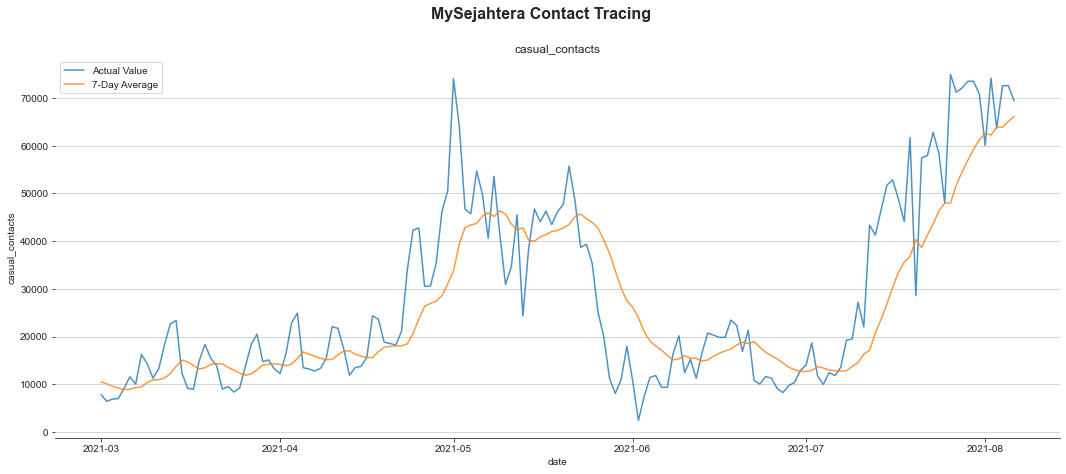

In [8]:
sns.set_style("ticks")
warnings.filterwarnings("ignore")
fig, ax = plt.subplots(1,1,figsize = (18, 7))
col = mysejahtera_columns[3]
sns.lineplot(x='date', y=col, data = covid_stats_df, label='Actual Value', alpha=0.8, ax = ax) # Actual Data
sns.lineplot(data=ExponentialSmoothing(covid_stats_df[col]).fit(smoothing_level=0.14).fittedvalues, label='7-Day Average', alpha=0.8, ax = ax) # Smoothed Value
sns.despine(top=True, right=True, left=True)
ax.set_title(col)
ax.grid(axis='y')

fig.suptitle("MySejahtera Contact Tracing", fontsize=16, fontweight='bold')
plt.legend()
plt.show()

## Hospitalization

### COVID-19 Patients

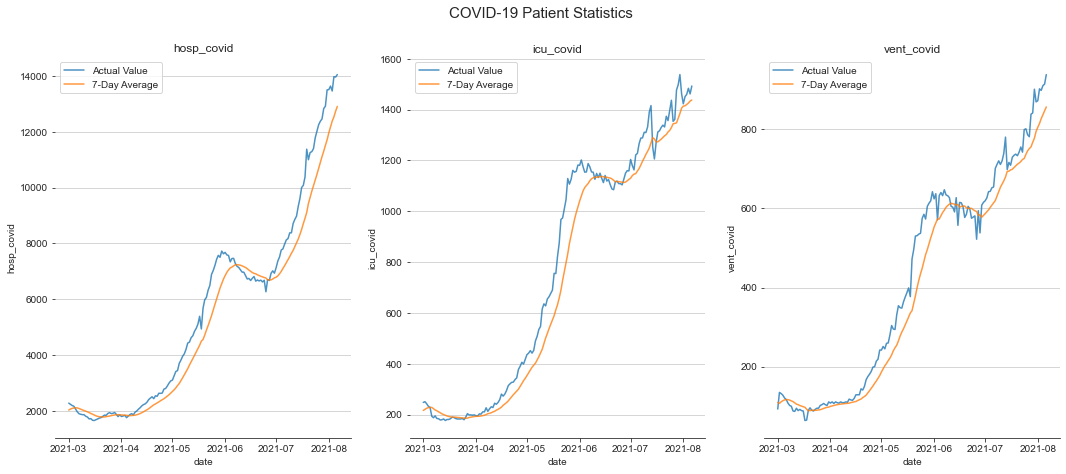

In [9]:
sns.set_style("ticks")
warnings.filterwarnings("ignore")
fig, axes = plt.subplots(1,3,figsize = (18, 7))
for idx, col in enumerate(patient_columns):
    sns.lineplot(x='date', y=col, data = covid_stats_df, label='Actual Value', alpha=0.8, ax = axes[idx]) # Actual Data
    sns.lineplot(data=ExponentialSmoothing(covid_stats_df[col]).fit(smoothing_level=0.14).fittedvalues, label='7-Day Average', alpha=0.8, ax = axes[idx]) # Smoothed Value
    sns.despine(top=True, right=True, left=True)
    axes[idx].set_title(col)
    axes[idx].grid(axis='y')

fig.suptitle("COVID-19 Patient Statistics", fontsize=15, fontweight='normal')
plt.legend()
plt.show()

### Hospital Capacity

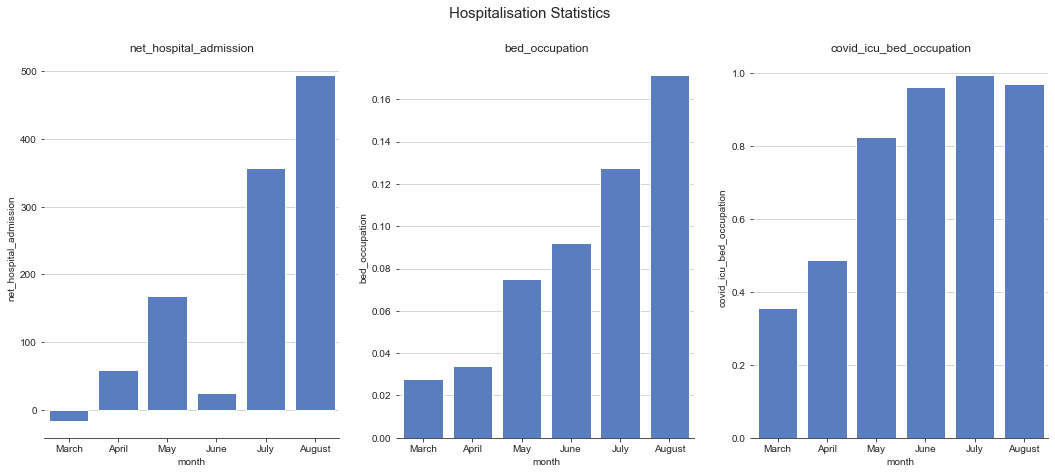

In [10]:
sns.set_style("ticks")
sns.set_color_codes("muted")
warnings.filterwarnings("ignore")

data = covid_stats_df.groupby(pd.Grouper(freq='M')).mean() # Group by Month
data['month'] = data.index.strftime("%B") # Set Month Column

fig, axes = plt.subplots(1,3,figsize = (18, 7))
for idx, col in enumerate(hospitalisation_columns):
    sns.barplot(x='month', y=col, data = data, ax = axes[idx], color='b')
    sns.despine(top=True, right=True, left=True)
    axes[idx].set_title(col)
    axes[idx].grid(axis='y')

fig.suptitle("Hospitalisation Statistics", fontsize=15, fontweight='normal')
plt.show()

# Time-Series Analysis
Prediction Period : 15-Day (Infectious Period)

Target Variable : ['cases_new', 'deaths_new']

Exogenous Variable New Cases: ['positiverate', 'checkins', 'uniqueind', 'uniqueloc', 'casualcontacts']

Exogenous Variable New Deaths: ['bed_occupation', 'covid_icu_bed_occupation']

## Stationary Test

In [104]:
target_variables = ['cases_new', 'deaths_new']
X_new_cases = ['positive_rate', 'checkins', 'unique_ind', 'unique_loc', 'casual_contacts']
X_new_deaths = ['positive_rate', 'bed_occupation', 'covid_icu_bed_occupation']
all_vars = target_variables+X_new_cases+X_new_deaths

In [12]:
p_value = []
for var in all_vars:
    p_value.append(adfuller(covid_stats_df[var])[1]) # Run Adfuller test to determine is the time-series Stationary

pd.DataFrame(dict(Variable = all_vars, P_Value = p_value, Stationary = [p<0.05 for p in p_value]))

,Variable,P_Value,Stationary
0,cases_new,0.991806,False
1,deaths_new,0.998586,False
2,positive_rate,0.999040,False
3,checkins,0.657611,False
4,unique_ind,0.227688,False
5,unique_loc,0.605397,False
6,casual_contacts,0.457640,False
7,positive_rate,0.999040,False
8,bed_occupation,0.976172,False
9,covid_icu_bed_occupation,0.822850,False


In [13]:
time_series_data_df = covid_stats_df[set(all_vars)].copy()

# Take 7 Day Smoothing for Prediction
time_series_data_df['cases_new'] = time_series_data_df['cases_new'].rolling(7).mean()
time_series_data_df['deaths_new'] = time_series_data_df['deaths_new'].rolling(7).mean()

# Take Double Difference of Natural Logarithm and for New Cases and Deaths to Make Stationary Series
time_series_data_df['cases_new_stationary'] = np.log(time_series_data_df['cases_new']).diff().diff()
time_series_data_df['deaths_new_stationary'] = np.log(time_series_data_df['deaths_new']).diff().diff()


# Shift 15-Day of Infectious Cycle for X_new_cases and X_new_deaths
for X in X_new_cases+X_new_deaths:
    time_series_data_df[f'{X}_shift15'] = time_series_data_df[X].shift(15)

time_series_data_df.dropna(inplace=True)

In [14]:
p_value = []
for var in [col+'_stationary' for col in target_variables]:
    p_value.append(adfuller(time_series_data_df[var])[1]) # Run Adfuller test to determine is the time-series Stationary

pd.DataFrame(dict(Variable = [col+'_stationary' for col in target_variables],P_Value = p_value, Stationary = [p<0.05 for p in p_value]))

,Variable,P_Value,Stationary
0,cases_new_stationary,0.029674,True
1,deaths_new_stationary,0.000071,True


## Auto-Correlation and Partial Auto-Correlation Plot

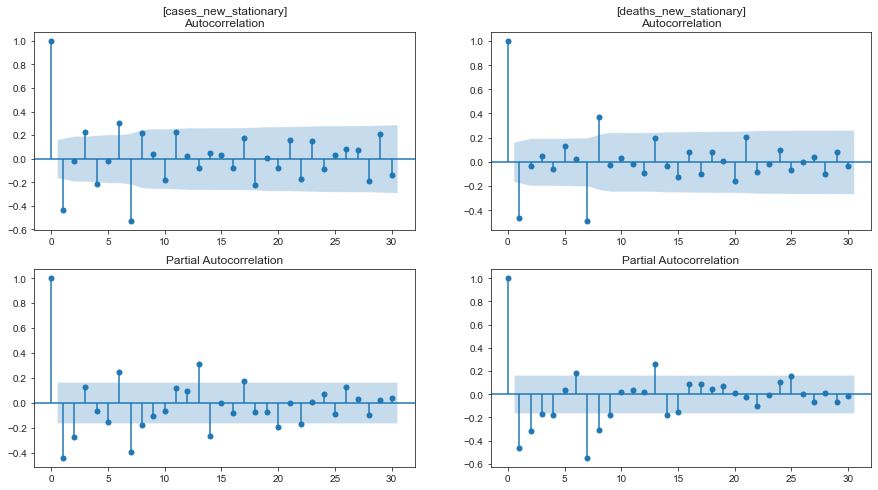

In [15]:
target_variables_stationary = [col+'_stationary' for col in target_variables]

fig, axes = plt.subplots(2,2, figsize = (15,8))
for idx, variable in enumerate(target_variables_stationary):
    plot_acf(time_series_data_df[variable], lags = 30, ax = axes[0, idx]) # Looks for MA(q)
    plot_pacf(time_series_data_df[variable], lags = 30, ax = axes[1, idx]) # Looks for AR(p)
    axes[0, idx].set_title("[{}]\nAutocorrelation".format(variable))
plt.show()

# Time-Series Modelling

## Cross-Validation Technique

In [16]:
TEST_SIZE = 15
# Log and Seperate Train and Test Data
train_data = np.log(time_series_data_df.iloc[:-TEST_SIZE]) 
test_data = np.log(time_series_data_df.iloc[-TEST_SIZE:])

def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

def expanding_window(model, endog, exog=None, test_size=15, n_splits=5, **kwargs):
    tscv = TimeSeriesSplit(test_size=test_size, n_splits = n_splits)
    rmse_hist = []
    aic_hist = []
    for idx, (train_index, test_index) in enumerate(tscv.split(endog)):
        if exog is not None:
            res = model(endog.iloc[train_index], exog.iloc[train_index], **kwargs).fit()
            yhat = res.forecast(test_size, exog = exog.iloc[test_index])
        else:
            res = model(endog.iloc[train_index], **kwargs).fit()
            yhat = res.forecast(test_size)
        ytrue = endog.iloc[test_index]
        rmse_hist.append(rmse(ytrue, yhat))
    return np.array(rmse_hist).mean(), res.aic

expanding_window(SARIMAX, train_data['cases_new'])

(0.23737590492941535, -441.97554504796375)

In [17]:
def expanding_window_baseline(endog:pd.Series, test_size=TEST_SIZE, n_splits=3):
    tscv = TimeSeriesSplit(test_size=test_size, n_splits = n_splits)
    # Array to Record all RMSE
    rmse_hist = []
    
    for iters, (train_index, test_index) in enumerate(tscv.split(endog)):     
        train = endog.iloc[train_index]
        test = endog.iloc[test_index]
        yhat = pd.Series(train.mean()).repeat(test_size)
        
        rmse_hist.append(rmse(test.values, yhat.values))

    return np.array(rmse_hist).mean()

base_hist = dict()
for var in target_variables:
    base_hist[var] = expanding_window_baseline(endog=train_data[var])
pd.DataFrame(base_hist, index = ['baseline_rmse']).T

,baseline_rmse
cases_new,0.844351
deaths_new,1.661896


## SARIMAX Hyperparameter Tuning

In [35]:
cv_hist_new_case = dict()
var = 'cases_new'

# Define Params Space
p_range = range(1,4)
d_range = [1,2]
q_range = range(1,4)
P_range = range(1,5)
D_range = [1,2]
Q_range = range(1,6)
m = [7]

for p, d, q, P, D, Q, m in tqdm(itertools.product(*(p_range, d_range, q_range, P_range, D_range, Q_range, m))):
    try:
        rmse_aic_tuple = expanding_window(SARIMAX, train_data[var], exog = train_data[[f'{col}_shift15' for col in X_new_cases]], order = (p,d,q), seasonal_order=(P,D,Q,m))
        cv_hist_new_case[f'({p},1,{q}),({P},{D},{Q},{m})'] = rmse_aic_tuple
    except:
        continue
print(f"{var} CV Result:")
print(pd.DataFrame(cv_hist_new_case, index=['rmse', 'aic']).T.sort_values(['rmse','aic']).head(20))

                       rmse         aic
(3,1,3),(2,1,5,7)  0.164569 -472.507654
(2,1,3),(4,1,4,7)  0.165784 -439.131497
(1,1,1),(4,2,4,7)  0.172306 -385.053649
(1,1,3),(3,1,1,7)  0.173243 -469.508697
(3,1,3),(1,1,2,7)  0.174090 -463.896544
(1,1,1),(2,2,3,7)  0.176640 -377.909467
(3,1,1),(2,2,3,7)  0.177232 -375.082785
(1,1,1),(2,2,4,7)  0.177842 -381.383939
(1,1,1),(4,2,3,7)  0.178194 -385.883535
(1,1,2),(1,1,2,7)  0.179536 -466.375882
(3,1,2),(2,2,3,7)  0.181669 -378.849108
(3,1,3),(2,1,4,7)  0.187594 -474.608781
(1,1,3),(1,1,2,7)  0.187602 -463.803990
(3,1,1),(3,2,4,7)  0.191381 -387.071487
(1,1,1),(3,2,4,7)  0.191848 -387.110270
(1,1,3),(2,1,1,7)  0.192212 -479.711564
(3,1,1),(3,2,5,7)  0.192432 -390.414294
(3,1,2),(2,1,3,7)  0.194063 -472.631005
(3,1,1),(4,1,1,7)  0.194145 -472.963544
(1,1,3),(1,1,5,7)  0.194355 -483.659377


In [33]:
cv_hist_new_death = dict()
var = 'deaths_new'

# Define Params Space
p_range = range(1,4)
d_range = [1,2]
q_range = range(1,4)
P_range = range(1,5)
D_range = [1,2]
Q_range = range(1,6)
m = [7]

for p, d, q, P, D, Q, m in tqdm(itertools.product(*(p_range, d_range, q_range, P_range, D_range, Q_range, m))):
    try:
        rmse_aic_tuple = expanding_window(SARIMAX, train_data[var], exog = train_data[[f'{col}_shift15' for col in X_new_deaths]], order = (p,d,q), seasonal_order=(P,D,Q,m))
        cv_hist_new_death[f'({p},1,{q}),({P},{D},{Q},{m})'] = rmse_aic_tuple
    except:
        continue
print(f"{var} CV Result:")
print(pd.DataFrame(cv_hist_new_death, index=['rmse', 'aic']).T.sort_values(['rmse','aic']).head(20))

                       rmse         aic
(3,1,1),(2,1,1,7)  0.284568 -268.765270
(1,1,1),(3,2,2,7)  0.297247 -182.066112
(1,1,1),(3,1,2,7)  0.300078 -268.859006
(1,1,1),(2,1,1,7)  0.302039 -272.818419
(3,1,1),(1,1,1,7)  0.304127 -245.740417
(2,1,3),(2,1,1,7)  0.306990 -267.207316
(3,1,1),(3,2,1,7)  0.309262 -187.997405
(1,1,2),(3,1,2,7)  0.309580 -267.069566
(1,1,2),(3,2,1,7)  0.310875 -189.968268
(1,1,2),(2,1,1,7)  0.311098 -271.041113
(1,1,1),(3,2,1,7)  0.311793 -191.946627
(1,1,3),(3,1,2,7)  0.312352 -265.238997
(3,1,2),(3,2,2,7)  0.312644 -176.529712
(2,1,2),(3,1,2,7)  0.313009 -265.162951
(1,1,3),(2,1,1,7)  0.313185 -269.134042
(1,1,2),(1,1,1,7)  0.313700 -247.016920
(3,1,1),(3,1,1,7)  0.314367 -269.134723
(2,1,2),(2,2,1,7)  0.315500 -182.403686
(3,1,1),(3,1,2,7)  0.316357 -264.776843
(1,1,1),(2,2,1,7)  0.316909 -186.115844


## SARIMAX Test Set Visualization

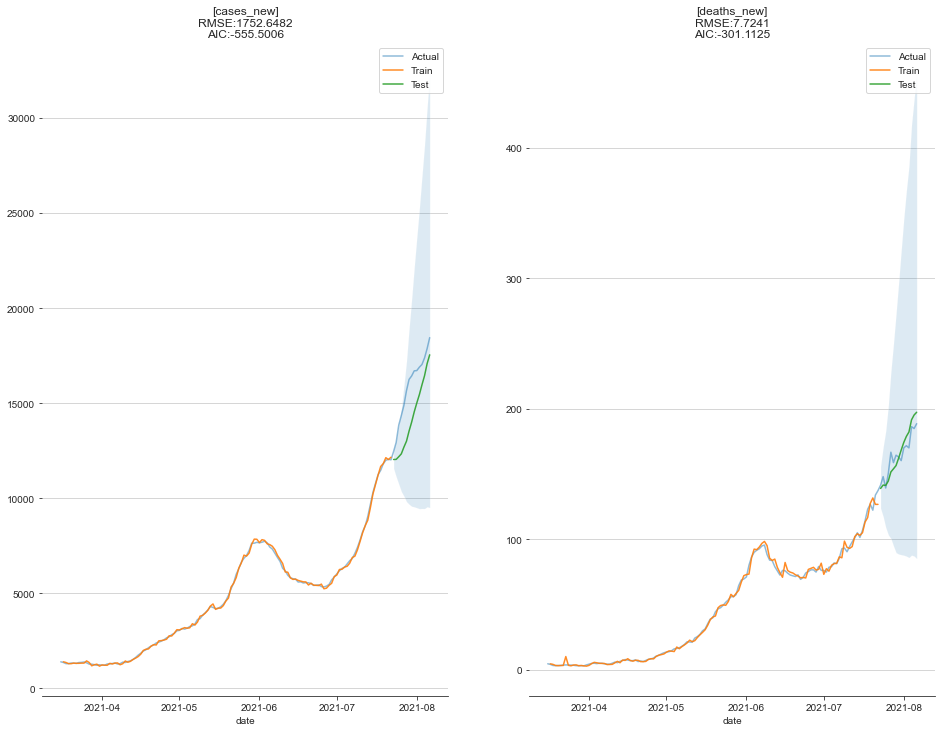

In [105]:
orders = [((2,1,1),(2,1,1,7)), ((3,1,1),(1,1,1,7))]
models = {}
fig, axes = plt.subplots(1,2, figsize=(16, 12))

for idx, order in enumerate(orders):
    mod = SARIMAX(train_data[target_variables[idx]], exog = train_data[[f'{col}_shift15' for col in [X_new_cases,X_new_deaths][idx]]], order = order[0], seasonal_order=order[1])
    res = mod.fit()
    models[target_variables[idx]] = res # Save the model for interpretation
    
    full_pred = res.predict()
    pred = res.forecast(test_data.shape[0], exog = test_data[[f'{col}_shift15' for col in [X_new_cases,X_new_deaths][idx]]])
    pred_ci = res.get_forecast(test_data.shape[0], exog = test_data[[f'{col}_shift15' for col in [X_new_cases,X_new_deaths][idx]]]).conf_int()
    
    axes[idx].set_title("[{}]\nRMSE:{:.4f}\nAIC:{:.4f}".format(
        target_variables[idx], 
        rmse(np.exp(test_data[target_variables[idx]]), np.exp(pred)),
        res.aic
    ))
    sns.lineplot(x = time_series_data_df[target_variables[idx]].index, y = time_series_data_df[target_variables[idx]].values, label = 'Actual', alpha=0.5, ax = axes[idx])
    sns.lineplot(x = np.exp(full_pred.iloc[1:]).index, y = np.exp(full_pred.replace({full_pred.max():np.nan}).fillna(method='ffill')).values[1:], label = 'Train', alpha=0.9, ax = axes[idx])
    sns.lineplot(x = np.exp(pred).index, y=np.exp(pred.values), label='Test', alpha=0.9, ax = axes[idx])
    sns.despine(top = True, left = True, right = True)
    axes[idx].fill_between(pred_ci.index, # 95% CI
                np.exp(pred_ci.iloc[:, 0]),
                np.exp(pred_ci.iloc[:, 1]), alpha=.15)
    axes[idx].grid(axis='y')
plt.legend()
plt.show()

## Model Interpretation

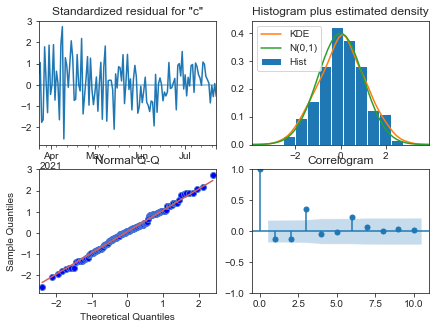

Model Interpretation for cases_new
                                     SARIMAX Results                                     
Dep. Variable:                         cases_new   No. Observations:                  129
Model:             SARIMAX(2, 1, 1)x(2, 1, 1, 7)   Log Likelihood                 289.750
Date:                           Thu, 12 Aug 2021   AIC                           -555.501
Time:                                   16:16:58   BIC                           -521.951
Sample:                               03-16-2021   HQIC                          -541.875
                                    - 07-22-2021                                         
Covariance Type:                             opg                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
positive_rate_shift15      -0.0038      0.008     -0.483     

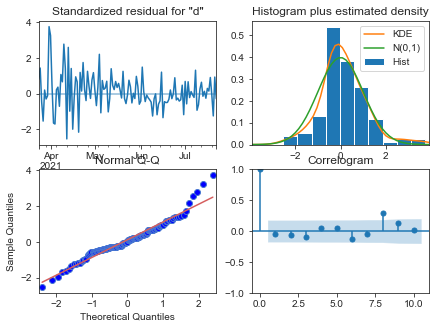

Model Interpretation for deaths_new
                                     SARIMAX Results                                     
Dep. Variable:                        deaths_new   No. Observations:                  129
Model:             SARIMAX(3, 1, 1)x(1, 1, 1, 7)   Log Likelihood                 160.556
Date:                           Thu, 12 Aug 2021   AIC                           -301.112
Time:                                   16:16:58   BIC                           -273.155
Sample:                               03-16-2021   HQIC                          -289.758
                                    - 07-22-2021                                         
Covariance Type:                             opg                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
positive_rate_shift15                0.012

In [106]:
for var, model in models.items():
    model.plot_diagnostics(figsize=(7,5))
    plt.show()
    print(f'Model Interpretation for {var}\n{model.summary()}\n')

# Future 15-Day Forecast with SARIMAX

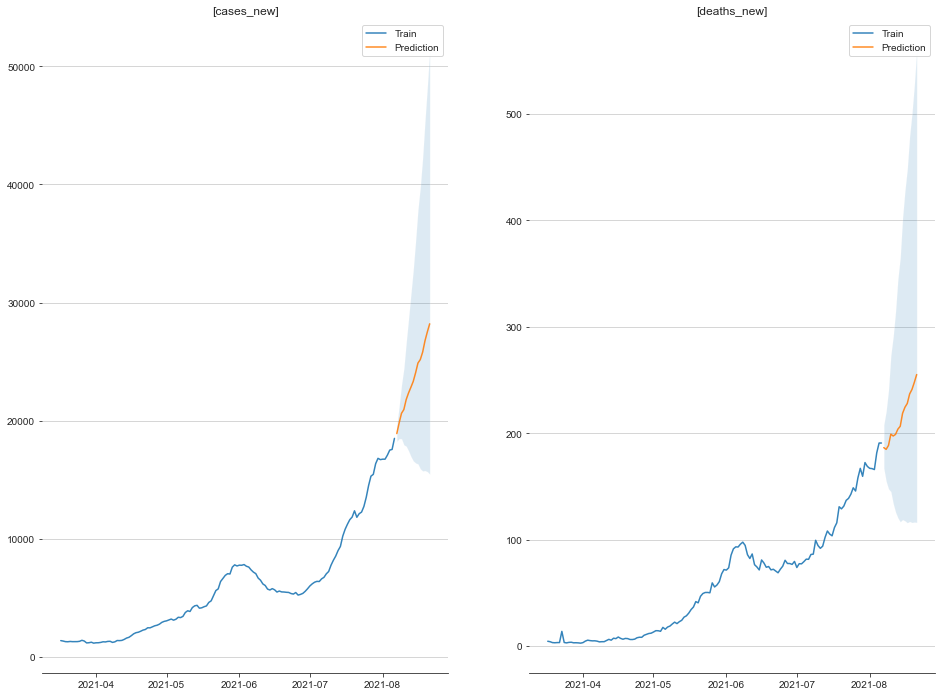

In [86]:
all_data = pd.concat([train_data, test_data], axis = 0)
X_future = all_data[set(X_new_deaths + X_new_cases)].iloc[-TEST_SIZE:]


orders = [((2,1,1),(2,1,1,7)), ((3,1,1),(1,1,1,7))]

fig, axes = plt.subplots(1,2, figsize=(16, 12))

for idx, order in enumerate(orders):
    mod = SARIMAX(all_data[target_variables[idx]], exog = all_data[[X_new_cases,X_new_deaths][idx]], order = order[0], seasonal_order=order[1])
    res = mod.fit()

    full_pred = res.predict()
    pred = res.forecast(TEST_SIZE, exog = X_future[[X_new_cases,X_new_deaths][idx]])
    pred_ci = res.get_forecast(TEST_SIZE, exog = X_future[[X_new_cases,X_new_deaths][idx]]).conf_int()

    axes[idx].set_title("[{}]".format(target_variables[idx]))
    sns.lineplot(x = np.exp(full_pred.iloc[1:]).index, y = np.exp(full_pred.replace({full_pred.max():np.nan}).fillna(method='ffill').iloc[1:]).values, label = 'Train', alpha=0.9, ax = axes[idx])
    sns.lineplot(x = np.exp(pred).index, y=np.exp(pred).values, label='Prediction', alpha=0.9, ax = axes[idx])
    sns.despine(top = True, left = True, right = True)
    axes[idx].fill_between(pred_ci.index,
                np.exp(pred_ci.iloc[:, 0]),
                np.exp(pred_ci.iloc[:, 1]), alpha=.15)
    axes[idx].grid(axis='y')
plt.legend()
plt.show()